In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/500


c:\Users\andta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154
Epoch 2/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164
Epoch 3/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166
Epoch 4/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 5/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148
Epoch 6/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157
Epoch 7/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 8/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 9/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 10/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 11/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 12/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 13/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 14/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144
Epoch 15/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

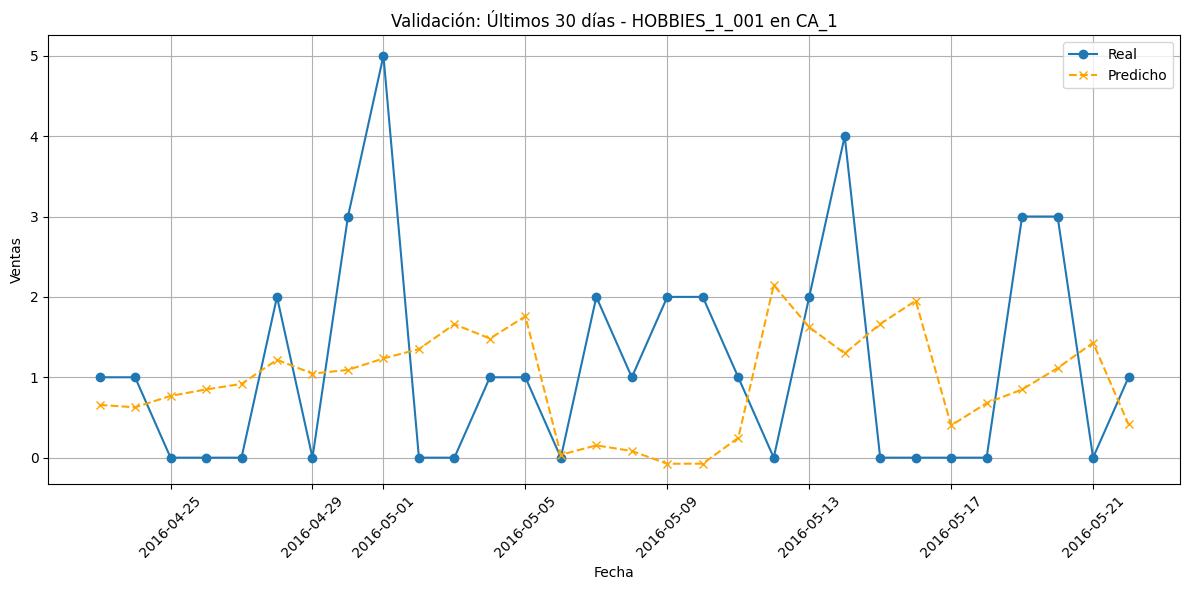

In [2]:
# === Parámetros ===
ITEM_ID = 'HOBBIES_1_001'
STORE_ID = 'CA_1'
N_PRED = 30           # días a predecir
N_STEPS = 30          # ventana de input
EPOCHS = 500
BATCH_SIZE = 16

# === 1. Cargar y filtrar datos ===

current_dir = os.getcwd()
lstm_path = os.path.join(current_dir, "../data/csv_model/final_data_filtered_lstm.csv")
df = pd.read_csv(lstm_path, parse_dates=['date'])
# Filtrar por tienda y producto
df_filtered = df[(df['item_id'] == ITEM_ID) & (df['store_id'] == STORE_ID)].copy()
# Ordenar por fecha
df_filtered = df_filtered.sort_values('date')
df_filtered.reset_index(drop=True, inplace=True)

# === 2. Preprocesamiento ===

sales = df_filtered['sales'].values.reshape(-1, 1)
# Escalado entre 0 y 1
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

# === 3. Dividir datos: entrenamiento y prueba para últimos 30 días ===

# Separar datos: entrenamiento hasta 30 días antes del final
train_data = sales_scaled[:-N_PRED]
test_data = sales_scaled[-(N_PRED + N_STEPS):]  # incluye la ventana necesaria para predecir

# Función para crear secuencias (ya la tienes, la volvemos a usar)
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train_data, N_STEPS)

# === 4. Definir y entrenar modelo LSTM ===

#Resulados aceptables, excepto r2_score. ## relu
model = Sequential([
    LSTM(64, activation='relu', input_shape=(N_STEPS, 1)),
    Dense(1)
])

## tanh
# model = Sequential([
#     LSTM(64, activation='tanh', return_sequences=True, input_shape=(N_STEPS, 1)),
#     Dropout(0.2),
#     LSTM(32, activation='tanh'),
#     Dense(1)
# ])

# model = Sequential([
#     LSTM(64, activation='tanh', return_sequences=True, input_shape=(N_STEPS, 1)),
#     LSTM(32, activation='tanh'),
#     Dense(16, activation='relu'),
#     Dense(1)
# ])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# === 5. Predecir los últimos 30 días reales ===

# Usamos la última ventana del conjunto de prueba
input_seq = test_data[:N_STEPS].reshape(1, N_STEPS, 1)

predictions = []
for _ in range(N_PRED):
    next_pred = model.predict(input_seq)[0][0]
    predictions.append(next_pred)
    # Desplazamos la secuencia para incluir la predicción
    input_seq = np.append(input_seq[:, 1:, :], [[[next_pred]]], axis=1)

# Invertimos el escalado
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# === 6. Mostrar resultados comparando con datos reales ===

# Fechas reales de los últimos 30 días
real_dates = df_filtered['date'].iloc[-N_PRED:]
real_values = df_filtered['sales'].iloc[-N_PRED:].values

# Visualizar
plt.figure(figsize=(12,6))
plt.plot(real_dates, real_values, label='Real', marker='o')
plt.plot(real_dates, predictions, label='Predicho', linestyle='--', color='orange', marker='x')
plt.title(f'Validación: Últimos {N_PRED} días - {ITEM_ID} en {STORE_ID}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Guardar comparación
comparison_df = pd.DataFrame({
    'date': real_dates,
    'real_sales': real_values,
    'predicted_sales': predictions
})
comparison_df.to_csv(f'validation_last_{N_PRED}_days_{ITEM_ID}_{STORE_ID}.csv', index=False)


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular métricas
mse = mean_squared_error(real_values, predictions)
mae = mean_absolute_error(real_values, predictions)
r2 = r2_score(real_values, predictions)

# Mostrar en pantalla
print(f"📊 Evaluación del modelo:")
print(f"➡️  MSE:  {mse:.2f}")
print(f"➡️  MAE:  {mae:.2f}")
print(f"➡️  R²:   {r2:.4f}")


📊 Evaluación del modelo:
➡️  MSE:  2.35
➡️  MAE:  1.29
➡️  R²:   -0.3030


In [4]:
baseline = np.mean(real_values)
baseline_preds = np.full_like(real_values, baseline)
baseline_r2 = r2_score(real_values, baseline_preds)
print(f"R² del modelo base (promedio): {baseline_r2:.4f}")


R² del modelo base (promedio): -0.0154
